Это ноутбук research. Здесь будут вестись все исследования и размышления

In [1]:
%load_ext autoreload
%autoreload 2

# План

1) Получить и обработать данные временного ряда
2) Перебрать лаги и собрать z вектора
3) Кластеризовать z вектора внутри одного паттерна, отобрать мотивы
4) Предскзание
    1. Пройтись по паттернам
    2. Найти ближайшие вектора / центры кластеров
    3. Берем у таких векторов последние значение и усредняем / медиана
    4. Если большая дисперсия или мало векторов -> Non-predictable
    5. Финальный ответ - среднее (взвешанное) по паттернам

# Кластеризация

Нужно реализовать модифицированный алгоритм кластеризации Уишарта. Для подбора гиперпараметров буду испольвать метрики оценки качества кластеризации силуэт скор, Халински-Карабах индекс, Дэвиc-Болдуин индекс.  



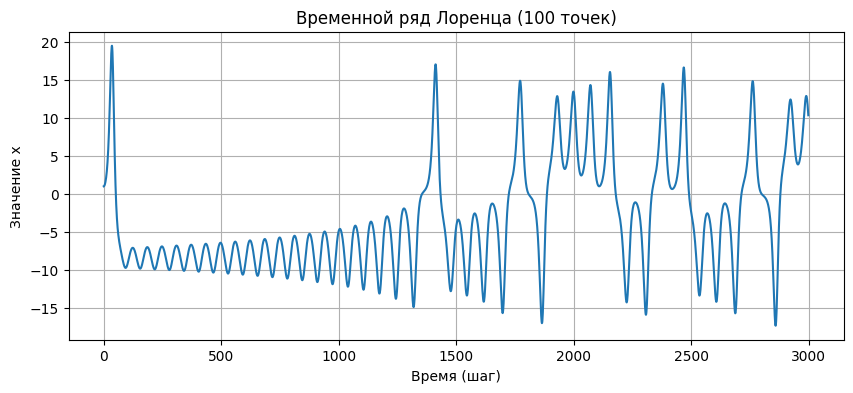

In [2]:
from utils import *
import matplotlib.pyplot as plt

lorenz_series = generate_lorenz_series(n_points=3000)

# Визуализируем временной ряд
plt.figure(figsize=(10, 4))
plt.plot(lorenz_series)
plt.title("Временной ряд Лоренца (100 точек)")
plt.xlabel("Время (шаг)")
plt.ylabel("Значение x")
plt.grid(True)
plt.show()

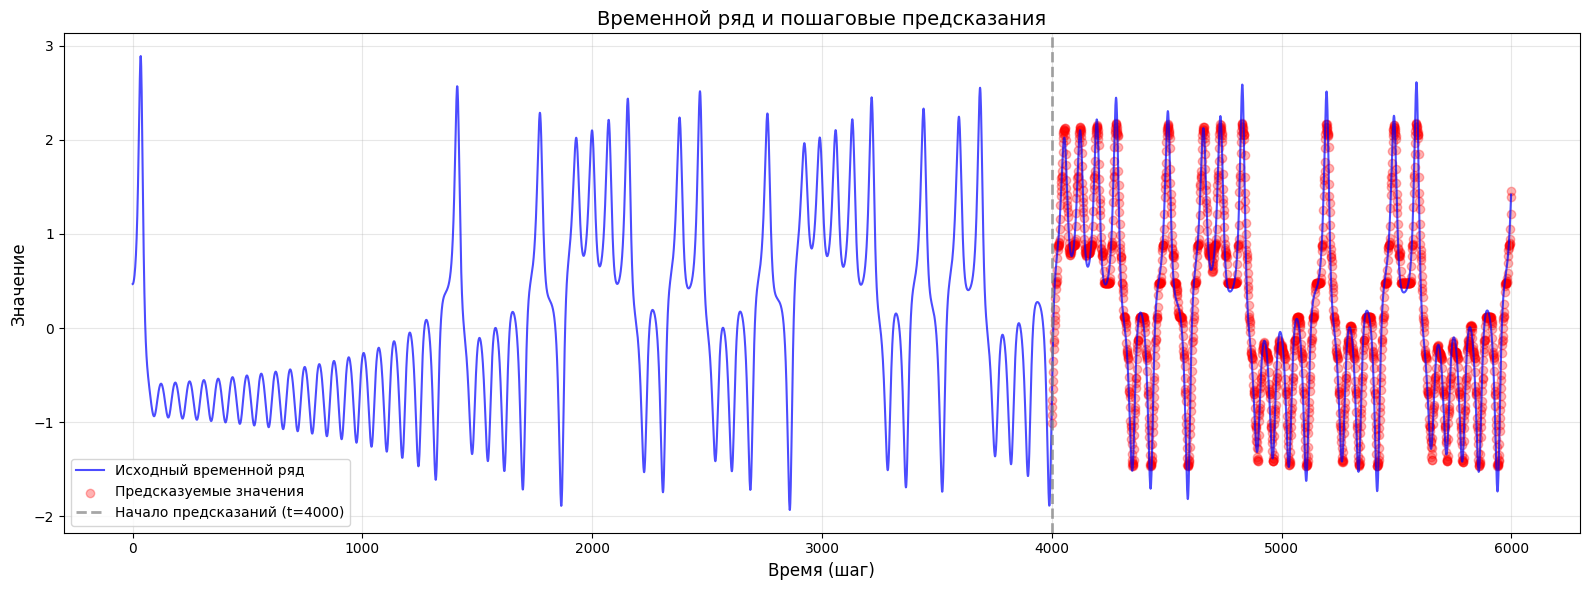

Сгенерировано предсказаний: 2000
MSE: 0.024840


In [24]:
from utils import generate_lorenz_series, generate_patterns, zscore_normalize
from clustering import KMeansPatternClustering
from prediction import MultiPatternPredictor
import matplotlib.pyplot as plt
import numpy as np

# генерация данных
series = generate_lorenz_series(n_points=6000)

# паттерны
patterns = generate_patterns(pattern_length=4, max_offset=10)

# модель
predictor = MultiPatternPredictor(
    patterns=patterns,
    horizon=1,
    n_clusters=15,
    min_cluster_size=10,
    max_target_std=2.0,
    cluster_method='kmeans'
)

# точка начала предсказаний
prediction_start = 4000
train_series = series[:prediction_start]
train_norm, mu, sigma = zscore_normalize(train_series)
# train_norm, min, max = minmax_normalize(train_series)
test_norm = (series[prediction_start:] - mu) / sigma

# обучение на данных до точки начала предсказаний
predictor.fit(train_norm)

# создаем расширенный ряд для предсказаний
# используем реальные значения до prediction_start, затем предсказания
extended_series = train_norm.copy()
predictions = []
x_pred = []

unpredictable = []
x_unpred = []

# генерируем предсказания пошагово
for i in range(prediction_start, len(series)):
    pred = predictor.predict(extended_series)
    if pred is None:
        unpredictable.append(test_norm[i - prediction_start])
        x_unpred.append(i)
    else:
        predictions.append(pred)
        x_pred.append(i)
    extended_series = np.append(extended_series, test_norm[i - prediction_start])

# визуализация
plt.figure(figsize=(16, 6))

# весь временной ряд
x_full = np.arange(len(series))
plt.plot(x_full, np.append(train_norm, test_norm), 'b-', label='Исходный временной ряд', linewidth=1.5, alpha=0.7)

# часть с предсказаниями
if len(predictions) > 0:
    x_pred = np.array(x_pred)
    plt.scatter(x_pred, predictions, color='r', label='Предсказуемые значения', alpha=0.3, marker='o')

if len(unpredictable) > 0:
    x_unpred = np.array(x_unpred)
    plt.scatter(x_unpred, unpredictable, color='g', label='Непредсказуемые значения', alpha=0.3, marker='o')

# граница обучения/предсказания
plt.axvline(x=prediction_start, color='gray', linestyle='--', linewidth=2, alpha=0.7, label=f'Начало предсказаний (t={prediction_start})')

plt.xlabel('Время (шаг)', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.title('Временной ряд и пошаговые предсказания', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Сгенерировано предсказаний: {len(predictions)}")
if len(predictions) > 0:
    mse = np.mean((predictions - test_norm[x_pred - prediction_start])**2)
    print(f"MSE: {mse:.6f}")


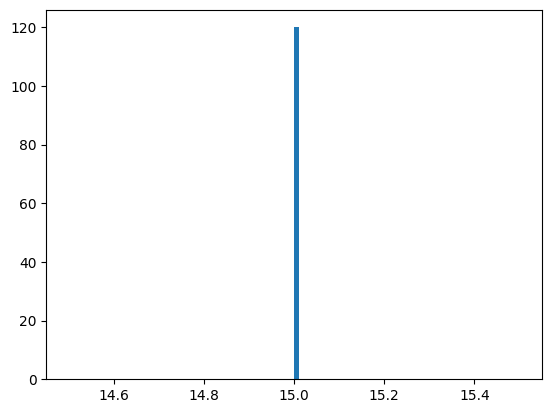

In [25]:
clusters = []
for i in range(len(predictor.clusterings)):
    clusters.append(len(predictor.clusterings[i].cluster_centers))

plt.hist(clusters, bins=100)
plt.show()

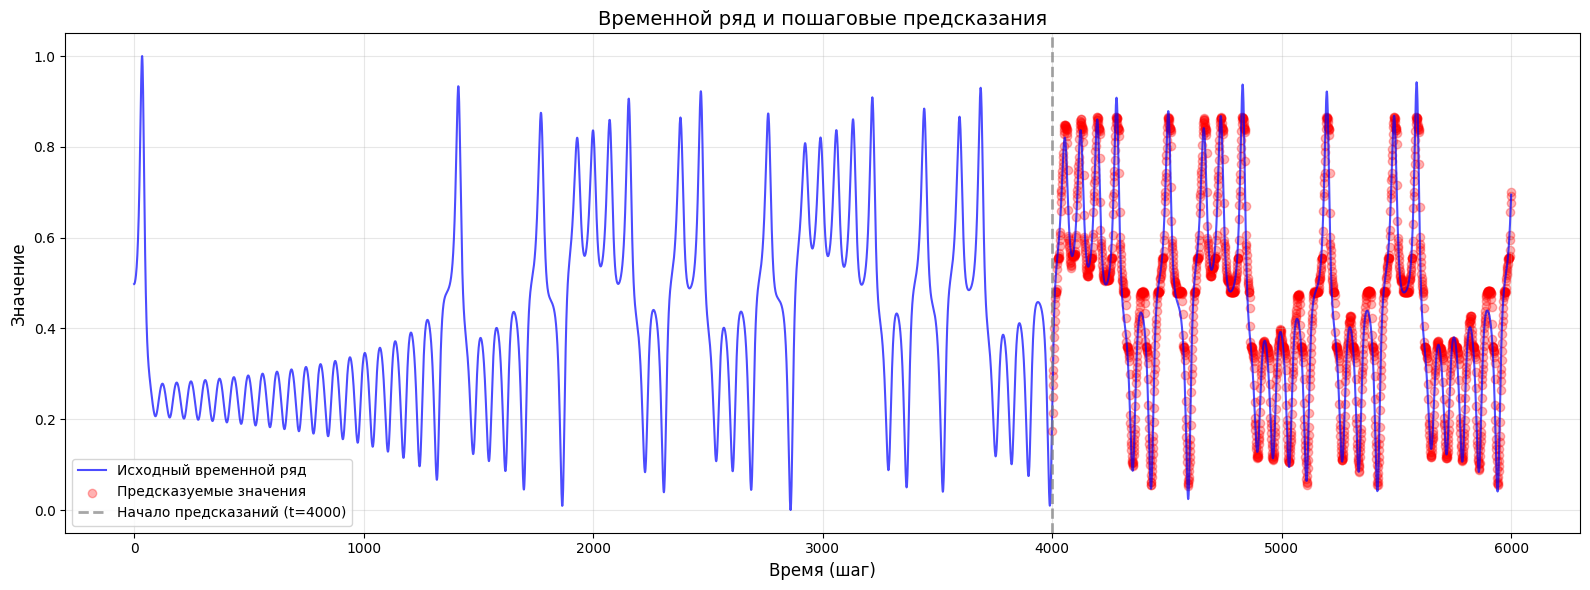

Сгенерировано предсказаний: 2000
MSE: 0.001151


In [ ]:
from utils import generate_lorenz_series, generate_patterns, zscore_normalize, min_max_normalize
from prediction import MultiPatternPredictor
import matplotlib.pyplot as plt
import numpy as np

# генерация данных
series = generate_lorenz_series(n_points=6000)

# паттерны
patterns = generate_patterns(pattern_length=4, max_offset=10)

# модель
predictor = MultiPatternPredictor(
    patterns=patterns,
    horizon=1,
    eps=0.01,
    min_cluster_size=5,
    max_target_std=1.0, 
    cluster_method='dbscan'
)

# точка начала предсказаний
prediction_start = 4000
train_series = series[:prediction_start]
# train_norm, mu, sigma = zscore_normalize(train_series)
# test_norm = (series[prediction_start:] - mu) / sigma

train_norm, min, max = minmax_normalize(train_series)
test_norm = (series[prediction_start:] - min) / (max - min)

# обучение на данных до точки начала предсказаний
predictor.fit(train_norm)

# создаем расширенный ряд для предсказаний
# используем реальные значения до prediction_start, затем предсказания
extended_series = train_norm.copy()
predictions = []
x_pred = []

unpredictable = []
x_unpred = []

# генерируем предсказания пошагово
for i in range(prediction_start, len(series)):
    pred = predictor.predict(extended_series)
    if pred is None:
        unpredictable.append(test_norm[i - prediction_start])
        x_unpred.append(i)
    else:
        predictions.append(pred)
        x_pred.append(i)
    extended_series = np.append(extended_series, test_norm[i - prediction_start])

# визуализация
plt.figure(figsize=(16, 6))

# весь временной ряд
x_full = np.arange(len(series))
plt.plot(x_full, np.append(train_norm, test_norm), 'b-', label='Исходный временной ряд', linewidth=1.5, alpha=0.7)

# часть с предсказаниями
if len(predictions) > 0:
    x_pred = np.array(x_pred)
    plt.scatter(x_pred, predictions, color='r', label='Предсказуемые значения', alpha=0.3, marker='o')

if len(unpredictable) > 0:
    x_unpred = np.array(x_unpred)
    plt.scatter(x_unpred, unpredictable, color='g', label='Непредсказуемые значения', alpha=0.3, marker='o')

# граница обучения/предсказания
plt.axvline(x=prediction_start, color='gray', linestyle='--', linewidth=2, alpha=0.7, label=f'Начало предсказаний (t={prediction_start})')

plt.xlabel('Время (шаг)', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.title('Временной ряд и пошаговые предсказания', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Сгенерировано предсказаний: {len(predictions)}")
if len(predictions) > 0:
    mse = np.mean((predictions - test_norm[x_pred - prediction_start])**2)
    print(f"MSE: {mse:.6f}")


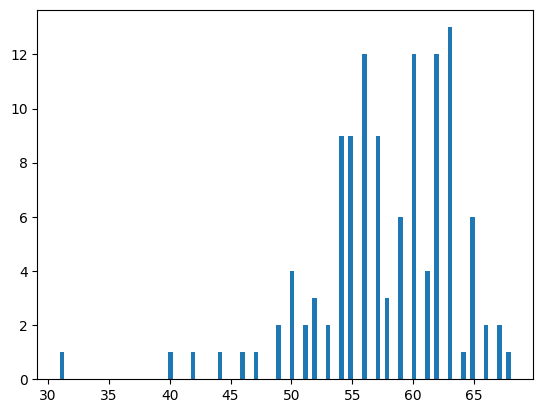

In [27]:
clusters = []
for i in range(len(predictor.clusterings)):
    clusters.append(len(predictor.clusterings[i].cluster_centers))

plt.hist(clusters, bins=100)
plt.show()


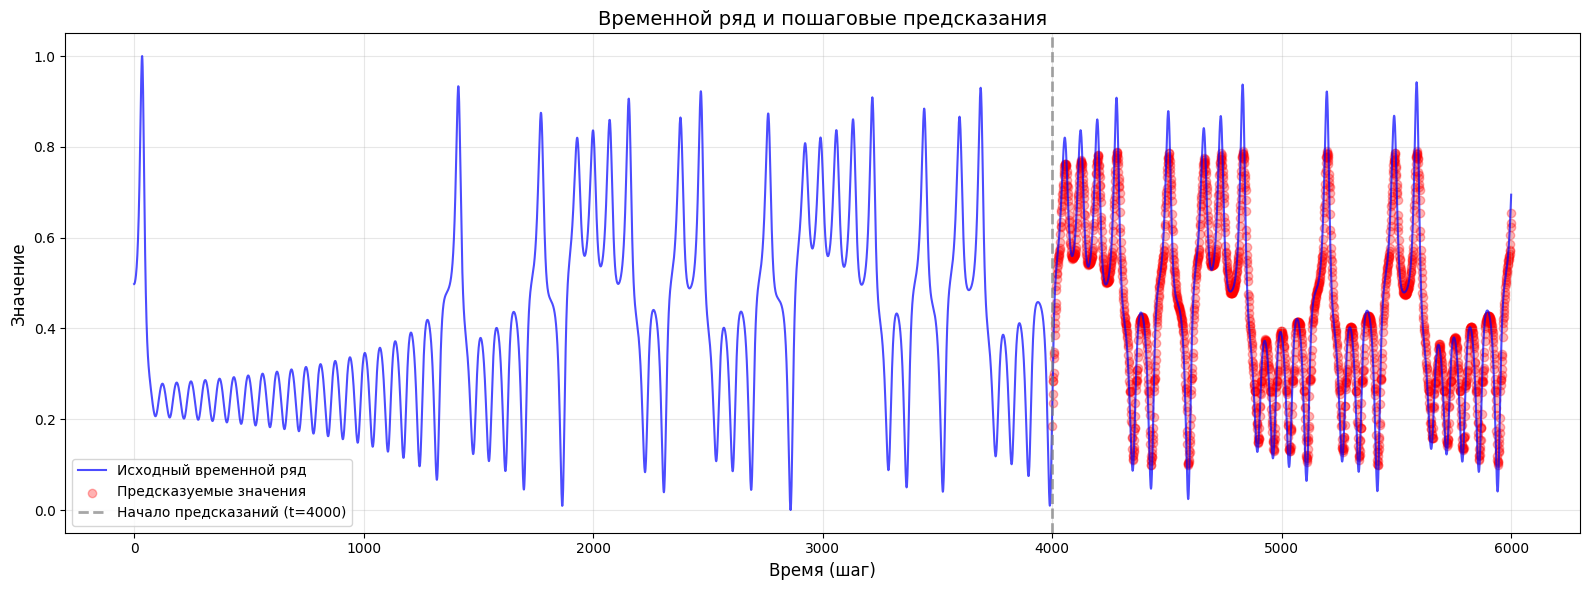

Сгенерировано предсказаний: 2000
MSE: 0.002174


In [ ]:
from utils import generate_lorenz_series, generate_patterns, zscore_normalize, min_max_normalize
from prediction import MultiPatternPredictor
import matplotlib.pyplot as plt
import numpy as np

# генерация данных
series = generate_lorenz_series(n_points=6000)

# паттерны
patterns = generate_patterns(pattern_length=4, max_offset=10)

# модель
predictor = MultiPatternPredictor(
    patterns=patterns,
    horizon=1,
    n_clusters=15,
    min_cluster_size=10,
    max_target_std=2.0, 
    cluster_method='wishart'
)

# точка начала предсказаний
prediction_start = 4000
train_series = series[:prediction_start]
# train_norm, mu, sigma = zscore_normalize(train_series)
# test_norm = (series[prediction_start:] - mu) / sigma

train_norm, min, max = minmax_normalize(train_series)
test_norm = (series[prediction_start:] - min) / (max - min)

# обучение на данных до точки начала предсказаний
predictor.fit(train_norm)

# создаем расширенный ряд для предсказаний
# используем реальные значения до prediction_start, затем предсказания
extended_series = train_norm.copy()
predictions = []
x_pred = []

unpredictable = []
x_unpred = []

# генерируем предсказания пошагово
for i in range(prediction_start, len(series)):
    pred = predictor.predict(extended_series)
    if pred is None:
        unpredictable.append(test_norm[i - prediction_start])
        x_unpred.append(i)
    else:
        predictions.append(pred)
        x_pred.append(i)
    extended_series = np.append(extended_series, test_norm[i - prediction_start])

# визуализация
plt.figure(figsize=(16, 6))

# весь временной ряд
x_full = np.arange(len(series))
plt.plot(x_full, np.append(train_norm, test_norm), 'b-', label='Исходный временной ряд', linewidth=1.5, alpha=0.7)

# часть с предсказаниями
if len(predictions) > 0:
    x_pred = np.array(x_pred)
    plt.scatter(x_pred, predictions, color='r', label='Предсказуемые значения', alpha=0.3, marker='o')

if len(unpredictable) > 0:
    x_unpred = np.array(x_unpred)
    plt.scatter(x_unpred, unpredictable, color='g', label='Непредсказуемые значения', alpha=0.3, marker='o')

# граница обучения/предсказания
plt.axvline(x=prediction_start, color='gray', linestyle='--', linewidth=2, alpha=0.7, label=f'Начало предсказаний (t={prediction_start})')

plt.xlabel('Время (шаг)', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.title('Временной ряд и пошаговые предсказания', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Сгенерировано предсказаний: {len(predictions)}")
if len(predictions) > 0:
    mse = np.mean((predictions - test_norm[x_pred - prediction_start])**2)
    print(f"MSE: {mse:.6f}")


In [ ]:
# Сгенерировано предсказаний: 2000
# MSE: 0.002174

clusters = []
for i in range(len(predictor.clusterings)):
    clusters.append(len(predictor.clusterings[i].cluster_centers))

plt.hist(clusters, bins=100)
plt.show()

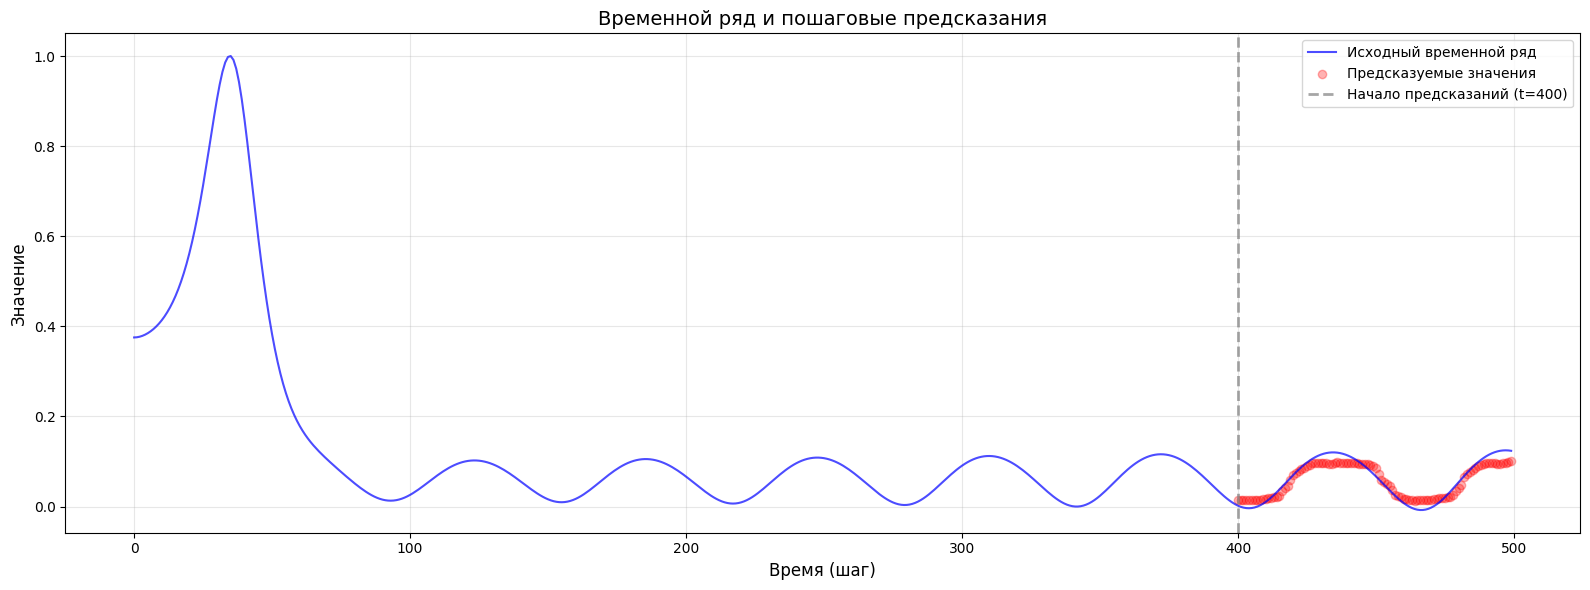

Сгенерировано предсказаний: 100
MSE: 0.000218


In [ ]:
from utils import generate_lorenz_series, generate_patterns, zscore_normalize, min_max_normalize
from prediction import MultiPatternPredictor
import matplotlib.pyplot as plt
import numpy as np

# генерация данных
series = generate_lorenz_series(n_points=500)

# паттерны
patterns = generate_patterns(pattern_length=4, max_offset=10)

# модель
predictor = MultiPatternPredictor(
    patterns=patterns,
    horizon=1,
    n_clusters=15,
    min_cluster_size=10,
    max_target_std=2.0, 
    cluster_method='wishart_fast'
)

# точка начала предсказаний
prediction_start = 400
train_series = series[:prediction_start]
# train_norm, mu, sigma = zscore_normalize(train_series)
# test_norm = (series[prediction_start:] - mu) / sigma

train_norm, min, max = minmax_normalize(train_series)
test_norm = (series[prediction_start:] - min) / (max - min)

# обучение на данных до точки начала предсказаний
predictor.fit(train_norm)

# создаем расширенный ряд для предсказаний
# используем реальные значения до prediction_start, затем предсказания
extended_series = train_norm.copy()
predictions = []
x_pred = []

unpredictable = []
x_unpred = []

# генерируем предсказания пошагово
for i in range(prediction_start, len(series)):
    pred = predictor.predict(extended_series)
    if pred is None:
        unpredictable.append(test_norm[i - prediction_start])
        x_unpred.append(i)
    else:
        predictions.append(pred)
        x_pred.append(i)
    extended_series = np.append(extended_series, test_norm[i - prediction_start])

# визуализация
plt.figure(figsize=(16, 6))

# весь временной ряд
x_full = np.arange(len(series))
plt.plot(x_full, np.append(train_norm, test_norm), 'b-', label='Исходный временной ряд', linewidth=1.5, alpha=0.7)

# часть с предсказаниями
if len(predictions) > 0:
    x_pred = np.array(x_pred)
    plt.scatter(x_pred, predictions, color='r', label='Предсказуемые значения', alpha=0.3, marker='o')

if len(unpredictable) > 0:
    x_unpred = np.array(x_unpred)
    plt.scatter(x_unpred, unpredictable, color='g', label='Непредсказуемые значения', alpha=0.3, marker='o')

# граница обучения/предсказания
plt.axvline(x=prediction_start, color='gray', linestyle='--', linewidth=2, alpha=0.7, label=f'Начало предсказаний (t={prediction_start})')

plt.xlabel('Время (шаг)', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.title('Временной ряд и пошаговые предсказания', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Сгенерировано предсказаний: {len(predictions)}")
if len(predictions) > 0:
    mse = np.mean((predictions - test_norm[x_pred - prediction_start])**2)
    print(f"MSE: {mse:.6f}")


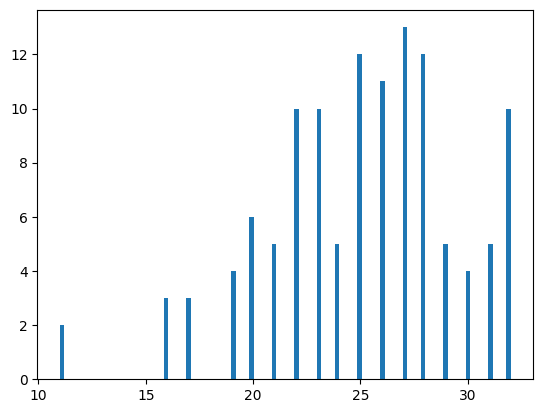

In [ ]:
# Сгенерировано предсказаний: 100
# MSE: 0.000218

clusters = []
for i in range(len(predictor.clusterings)):
    clusters.append(len(predictor.clusterings[i].cluster_centers))

plt.hist(clusters, bins=100)
plt.show()

Видно что кластеризация Уишарта работает сильно лучше, mse меньше на порядок

# Ценовой ряд Биткоина

Гипотеза 1: обозначим за точку входа момент времени ряда после которого через h шагов цена выросла на a процентов, соберем такие точки на обучающей выборке и кластеризуем, посмотрим для точек на валидации что для точек входа соседей в окрестности в этом простанстве будет больше, чем для обычной точки. 

Из гипотезы 1 можно вывести Стратегию 1: если текущая точка похода на точки входа из прошлого, то входим в позицию (покупаем), если через h шагов не получили a процентов, то закрываем позицию (продаем)

In [1]:
import pandas as pd

df = pd.read_csv('BTC2021.csv')

df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1638083640,2021-11-28 07:14:00,BTC/USD,54566.64,54566.64,54566.64,54566.64,0.001892,103.232989
1,1638083580,2021-11-28 07:13:00,BTC/USD,54526.68,54570.14,54526.68,54566.86,0.020604,1124.321776
2,1638083520,2021-11-28 07:12:00,BTC/USD,54514.00,54526.69,54457.60,54526.69,5.558807,303103.330791
3,1638083460,2021-11-28 07:11:00,BTC/USD,54520.37,54520.37,54520.37,54520.37,0.000000,0.000000
4,1638083400,2021-11-28 07:10:00,BTC/USD,54533.80,54539.26,54520.37,54520.37,0.039170,2135.562893


In [2]:
print(len(df))
print(df['date'].min(), df['date'].max())


477074
2021-01-01 00:01:00 2021-11-28 07:14:00


In [3]:
df['unix'] = (df['unix'] - df['unix'].min()) // 60
series = df[['unix', 'open']].sort_values('unix').set_index('unix')
lim = 3000
series = series[:lim]
print(series.shape, series.index.min(), series.index.max())
series.head()

(3000, 1) 0 2999


,open
unix,
0,29007.31
1,29069.80
2,29037.68
3,29048.13
4,29021.86


In [4]:
h = 1
diff = 0.001

series['is_entry'] = series['open'] * (1 + diff) <= series['open'].shift(-h)
series['is_entry'] = series['is_entry'].fillna(False)
series['is_entry'].value_counts()


is_entry
False    2551
True      449
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

train_size, val_size, test_size = 0.7, 0.15, 0.15

train = series[:int(len(series) * train_size)]
val = series[int(len(series) * train_size):int(len(series) * (train_size + val_size))]
test = series[int(len(series) * (train_size + val_size)):]

print(train.shape, val.shape, test.shape)

train.head()


(2100, 2) (450, 2) (450, 2)


,open,is_entry
unix,,
0,29007.31,True
1,29069.80,False
2,29037.68,False
3,29048.13,False
4,29021.86,False


In [ ]:
from clustering import WishartClusteringFast
from utils import min_max_normalize, generate_patterns
import numpy as np

patterns = generate_patterns(pattern_length=6, max_offset=10)

price_series, min, max = min_max_normalize(train['open'].to_numpy())
print(price_series.shape, min, max)
print(price_series[:10])
is_entry = train['is_entry'].to_numpy()
z_vectors = []
clusterings = []

for index, pattern in enumerate(patterns):
    print(f'{index} / {len(patterns)}')
    z_vectors.append([])
    max_lag = np.max(pattern)
    for t in range(max_lag, len(price_series)):
        if is_entry[t]:
            indices = t - pattern
            z_vectors[index].append(price_series[indices])
    clusterings.append(WishartClusteringFast(r=11, mu=0.2))
    clusterings[-1].fit(z_vectors[-1])

(2100,) 28785.98 29950.91
[0.18999425 0.24363696 0.21606448 0.22503498 0.20248427 0.18089499
 0.18454328 0.17816521 0.13667774 0.12619642]
0 / 120
1 / 120
2 / 120
3 / 120
4 / 120
5 / 120
6 / 120
7 / 120
8 / 120
9 / 120
10 / 120
11 / 120
12 / 120
13 / 120
14 / 120
15 / 120
16 / 120
17 / 120
18 / 120
19 / 120
20 / 120
21 / 120
22 / 120
23 / 120
24 / 120
25 / 120
26 / 120
27 / 120
28 / 120
29 / 120
30 / 120
31 / 120
32 / 120
33 / 120
34 / 120
35 / 120
36 / 120
37 / 120
38 / 120
39 / 120
40 / 120
41 / 120
42 / 120
43 / 120
44 / 120
45 / 120
46 / 120
47 / 120
48 / 120
49 / 120
50 / 120
51 / 120
52 / 120
53 / 120
54 / 120
55 / 120
56 / 120
57 / 120
58 / 120
59 / 120
60 / 120
61 / 120
62 / 120
63 / 120
64 / 120
65 / 120
66 / 120
67 / 120
68 / 120
69 / 120
70 / 120
71 / 120
72 / 120
73 / 120
74 / 120
75 / 120
76 / 120
77 / 120
78 / 120
79 / 120
80 / 120
81 / 120
82 / 120
83 / 120
84 / 120
85 / 120
86 / 120
87 / 120
88 / 120
89 / 120
90 / 120
91 / 120
92 / 120
93 / 120
94 / 120
95 / 120
96 / 12

In [10]:
price_series_test = (test['open'].to_numpy() - min) / (max - min)
print(price_series_test[:10])
is_entry_test = test['is_entry'].to_numpy()

sum_entry_points, cnt_entry_points = 0, 0
sum_other_points, cnt_other_points = 0, 0

for index, pattern in enumerate(patterns):
    print(f'{index} / {len(patterns)}')
    max_lag = np.max(pattern)
    for t in range(max_lag, len(price_series_test)):
        indices = t - pattern
        z_vector = price_series_test[indices]

        dists = np.linalg.norm(clusterings[index].cluster_centers_ - z_vector, axis=1)
        best = np.argmin(dists)
        
        if is_entry_test[t]:
            sum_entry_points += dists[best]
            cnt_entry_points += 1
        else:
            sum_other_points += dists[best]
            cnt_other_points += 1

print('entry', sum_entry_points / cnt_entry_points)
print('other', sum_other_points / cnt_other_points)

[3.38843536 3.40192115 3.42629171 3.451246   3.44571777 3.4508082
 3.39633283 3.40087387 3.40510589 3.40758672]
0 / 120
1 / 120
2 / 120
3 / 120
4 / 120
5 / 120
6 / 120
7 / 120
8 / 120
9 / 120
10 / 120
11 / 120
12 / 120
13 / 120
14 / 120
15 / 120
16 / 120
17 / 120
18 / 120
19 / 120
20 / 120
21 / 120
22 / 120
23 / 120
24 / 120
25 / 120
26 / 120
27 / 120
28 / 120
29 / 120
30 / 120
31 / 120
32 / 120
33 / 120
34 / 120
35 / 120
36 / 120
37 / 120
38 / 120
39 / 120
40 / 120
41 / 120
42 / 120
43 / 120
44 / 120
45 / 120
46 / 120
47 / 120
48 / 120
49 / 120
50 / 120
51 / 120
52 / 120
53 / 120
54 / 120
55 / 120
56 / 120
57 / 120
58 / 120
59 / 120
60 / 120
61 / 120
62 / 120
63 / 120
64 / 120
65 / 120
66 / 120
67 / 120
68 / 120
69 / 120
70 / 120
71 / 120
72 / 120
73 / 120
74 / 120
75 / 120
76 / 120
77 / 120
78 / 120
79 / 120
80 / 120
81 / 120
82 / 120
83 / 120
84 / 120
85 / 120
86 / 120
87 / 120
88 / 120
89 / 120
90 / 120
91 / 120
92 / 120
93 / 120
94 / 120
95 / 120
96 / 120
97 / 120
98 / 120
99 / 12

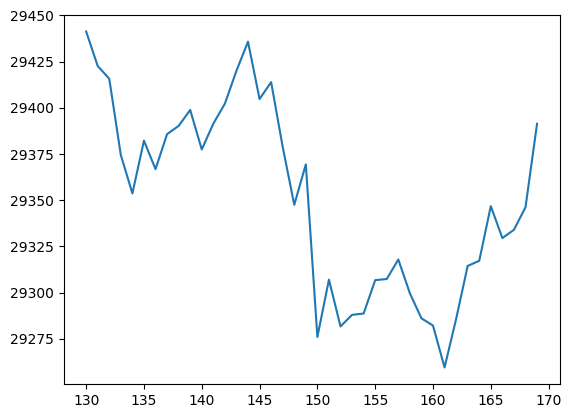

In [14]:
import matplotlib.pyplot as plt
plt.plot(train['open'][130:170])